In [ ]:
import pandas as pd
import time

In [ ]:
pip install nba_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.0/319.0 kB 6.2 MB/s eta 0:00:00


In [ ]:
from nba_api.stats.endpoints import leaguedashplayerstats, leaguedashplayerbiostats

In [ ]:
pergamedata = []
seasons = ['2023-24', '2022-23', '2021-22', '2020-21', '2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14', '2012-13', '2011-12', '2010-11']

In [ ]:
for season in seasons:
  print(f'Fetching {season}...')
  time.sleep(1)

  try:
    stats = leaguedashplayerstats.LeagueDashPlayerStats(season=season, per_mode_detailed='PerGame')
    df = stats.get_data_frames()[0]

    bio = leaguedashplayerbiostats.LeagueDashPlayerBioStats(season=season)
    bio_df = bio.get_data_frames()[0]

    merged = df.merge(bio_df[['PLAYER_ID', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT']], on = 'PLAYER_ID', how = 'left')
    merged['SEASON'] = season
    pergamedata.append(merged)
  except Exception as e:
    print(f"Error fetching data for {season}: {e}. Skipping this season.")
    continue

Fetching 2023-24...
Fetching 2022-23...
Fetching 2021-22...
Fetching 2020-21...
Fetching 2019-20...
Fetching 2018-19...
Fetching 2017-18...
Fetching 2016-17...
Fetching 2015-16...
Fetching 2014-15...
Fetching 2013-14...
Fetching 2012-13...
Fetching 2011-12...
Fetching 2010-11...


In [ ]:
pergame_df = pd.concat(pergamedata, ignore_index = True)
pergame_df = pergame_df[pergame_df['GP'] >= 25]
pergame_df = pergame_df.sort_values(by='GP', ascending=False).drop_duplicates(subset=['PLAYER_ID', 'SEASON'], keep='first')

In [ ]:
def calculate_TS(row):
  row['TS%'] = row.PTS / (2 * (row.FGA + 0.44 * row.FTA)) * 100
  return row

pergame_df = pergame_df.apply(calculate_TS, axis = 1)

def calculate_Eff(row):
  row['EFF'] = (1.1 * row.PTS) + row.AST + (0.5 * row.REB) + row.STL + row.BLK - row.TOV - (row.FGA - row.FGM) - (row.FTA - row.FTM)
  return row

def calculate_Pos(row):
  if row.PLAYER_HEIGHT_INCHES < 79.0:
    row['POS'] = 'G'
  elif row.PLAYER_HEIGHT_INCHES < 82.0:
    row['POS'] = 'F'
  else:
    row['POS'] = 'C'
  return row

pergame_df = pergame_df.apply(calculate_Eff, axis = 1)
pergame_df = pergame_df.apply(calculate_Pos, axis = 1)
pergame_df
pergame_df.to_csv('pergame_data_extra.csv', index = False)

In [ ]:
#Gives highest eff player in df
max_eff_player = pergame_df.loc[pergame_df['EFF'].idxmax()]
print(max_eff_player[['PLAYER_NAME', 'SEASON', 'EFF']])

#Gives df of specific age and position
pergame_df.loc[(pergame_df.AGE == 39.0) & (pergame_df.POS == 'C')].sort_values(by='EFF', ascending = False)

In [ ]:
age_analysis = pergame_df.groupby(['AGE', 'POS']).agg(
    PTS_Avg=('PTS', 'mean'),
    PLUS_MINUS_Avg=('PLUS_MINUS', 'mean'),
    AST_Avg=('AST', 'mean'),
    REB_Avg=('REB', 'mean'),
    TS_Avg=('TS%', 'mean'),
    EFF_Avg=('EFF', 'mean'),
    sample_size=('PLAYER_NAME', 'count')
).round(2)
display(age_analysis.sort_values(by='EFF_Avg', ascending=False))


PTS_Avg  PLUS_MINUS_Avg  AST_Avg  REB_Avg  TS_Avg  EFF_Avg  \
AGE  POS                                                               
39.0 C      11.05            2.12     1.70     6.75   56.18    12.56   
27.0 C      10.75            0.52     1.55     6.47   57.80    12.16   
28.0 C      10.61            0.98     1.60     6.64   58.17    12.15   
37.0 C       9.99            1.61     1.81     6.86   56.03    11.97   
38.0 C       9.74            1.30     1.96     7.28   50.87    11.71   
...           ...             ...      ...      ...     ...      ...   
42.0 G       7.40           -2.40     1.10     2.60   56.09     7.04   
41.0 G       5.40           -1.20     1.20     2.60   52.29     5.94   
     C       7.30           -1.30     0.70     3.10   46.56     5.48   
43.0 G       5.00           -2.10     0.80     2.10   46.99     4.15   
40.0 F       2.85           -0.30     0.70     2.00   49.32     3.24   

          sample_size  
AGE  POS               
39.0 C              4  
27.0 C            114  
28.0 C            109  
37.0 C              7  
38.0 C              5  
...               ...  
42.0 G              1  
41.0 G              1  
     C              1  
43.0 G              1  
40.0 F              2  

[70 rows x 7 columns]

In [ ]:
top_5_efficiencies = pergame_df.groupby(['SEASON', 'POS']).apply(lambda x: x.sort_values(by='EFF', ascending=False).head(5)).reset_index(drop=True)
#display(top_5_efficiencies)
top_age_analysis = top_5_efficiencies.groupby(['AGE', 'POS']).agg(
    PTS_Avg=('PTS', 'mean'),
    PLUS_MINUS_Avg=('PLUS_MINUS', 'mean'),
    TS_Avg=('TS%', 'mean'),
    EFF_Avg=('EFF', 'mean'),
    sample_size=('PLAYER_NAME', 'count')
).round(2)
#print(age_analysis.sort_values(by='EFF_Avg', ascending=False))


/tmp/ipython-input-110859468.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_efficiencies = pergame_df.groupby(['SEASON', 'POS']).apply(lambda x: x.sort_values(by='EFF', ascending=False).head(5)).reset_index(drop=True)


In [ ]:
player_names = ['Luka Dončić', 'Shai Gilgeous-Alexander', 'Nikola Jokić', 'Karl-Anthony Towns', 'DeMarcus Cousins']
examples_df = pergame_df.loc[pergame_df['PLAYER_NAME'].isin(player_names)]
display(examples_df)

In [ ]:
import seaborn as sns

[Text(0.5, 1.0, 'Effeciency Trajectory of the Leage Average at Each Position')]

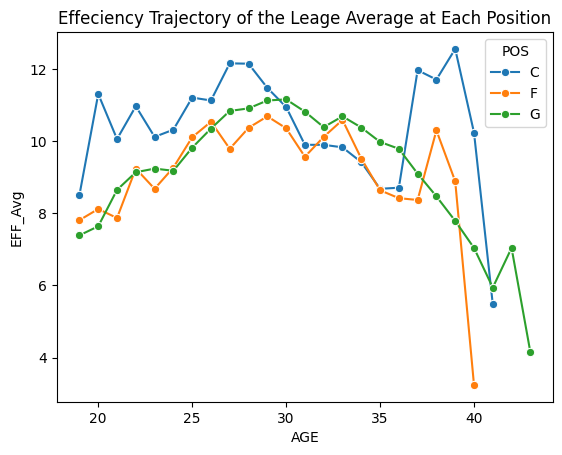

In [ ]:
all = sns.lineplot(data = age_analysis, x = 'AGE', y = 'EFF_Avg', hue = 'POS', marker = 'o', linewidth = 1.5)
all.set(title = 'Effeciency Trajectory of the Leage Average at Each Position')

In [ ]:
max_eff = age_analysis.loc[age_analysis.groupby('POS')['EFF_Avg'].idmax()]
display(max_eff[['AGE', 'POS', 'EFF_Avg']])


AttributeError: 'SeriesGroupBy' object has no attribute 'idmax'

(10.0, 40.0)

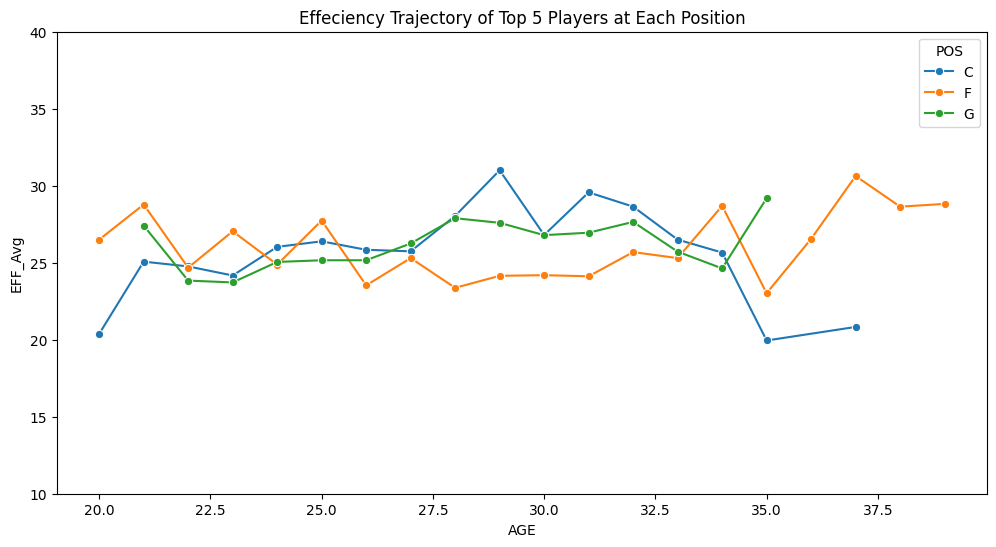

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
good = sns.lineplot(data = top_age_analysis, x = 'AGE', y = 'EFF_Avg', hue = 'POS', marker = 'o')
good.set(title = 'Effeciency Trajectory of Top 5 Players at Each Position')
good.set_ylim(10, 40) # Set a wider range for EFF_Avg

<Axes: xlabel='AGE', ylabel='EFF'>

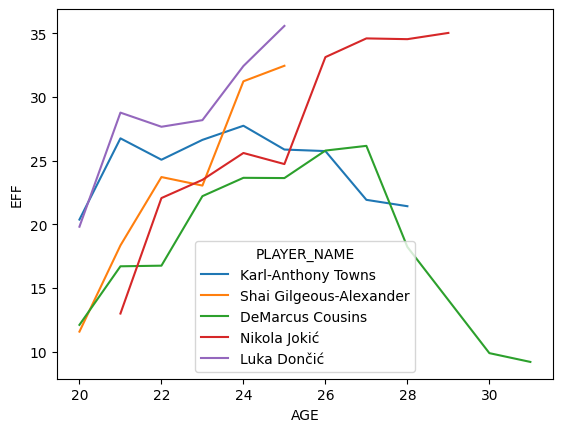

In [ ]:
sns.lineplot(data = examples_df, x = 'AGE', y = 'EFF', hue = 'PLAYER_NAME')